In [42]:
!pip install lightgbm --install-option=--gpu

D:\anaconda3\lib\site-packages\pip\_internal\commands\install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)


# LightGBM

## データセットの確認

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

# LightGBM
import lightgbm as lgb

# sciket-learn(評価算出)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [3]:
classes = pd.read_csv('kmnist_classmap.csv')

In [4]:
print(classes.shape)

(10, 3)


In [5]:
classes

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


In [6]:
X_train = np.load('kmnist-train-imgs.npz')['arr_0']
y_train = np.load('kmnist-train-labels.npz')['arr_0']

X_test = np.load('kmnist-test-imgs.npz')['arr_0']
y_test = np.load('kmnist-test-labels.npz')['arr_0']

In [7]:
# 訓練データは6万画像、各28x28の1チャンネル（グレースケール）で準備されている
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [8]:
# ここの8は「れ」を意味する
print(y_train[0:5])
print(classes)

[8 7 0 1 4]
   index codepoint char
0      0    U+304A    お
1      1    U+304D    き
2      2    U+3059    す
3      3    U+3064    つ
4      4    U+306A    な
5      5    U+306F    は
6      6    U+307E    ま
7      7    U+3084    や
8      8    U+308C    れ
9      9    U+3092    を


In [9]:
# わかりやすいようにindexをつける
labelindex = classes.set_index('index').to_dict()['char']
labelindex

{0: 'お',
 1: 'き',
 2: 'す',
 3: 'つ',
 4: 'な',
 5: 'は',
 6: 'ま',
 7: 'や',
 8: 'れ',
 9: 'を'}

In [10]:
# 以下により最小値0、最大値255ということで256階調を示していることを確認
print(X_train.min())
print(X_train.max())

0
255


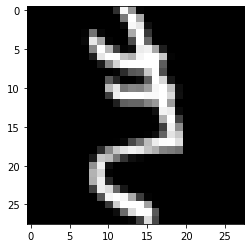

In [11]:
plt.imshow(X_train[423], cmap=plt.cm.gray)
plt.show()

In [12]:
# trainデータを可視化。423のデータを確認してみる
print(y_train[423])
print(labelindex[1])

1
き


## データ前処理

In [13]:
X_train[0,10:15, 10:15]

array([[  0,   0, 133,  91,   7],
       [  0,   0, 128, 128,  20],
       [  0,   0,  95, 224,  20],
       [  0,   0, 112, 159,  64],
       [  0,   1, 211, 234, 253]], dtype=uint8)

In [14]:
X_train.shape

(60000, 28, 28)

In [15]:
# データの一部確認
X_train[0, 10:15, 10:15]

array([[  0,   0, 133,  91,   7],
       [  0,   0, 128, 128,  20],
       [  0,   0,  95, 224,  20],
       [  0,   0, 112, 159,  64],
       [  0,   1, 211, 234, 253]], dtype=uint8)

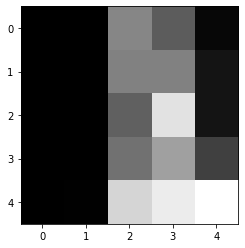

In [16]:
plt.imshow(X_train[0, 10:15, 10:15], cmap=plt.cm.gray)
plt.show()

In [17]:
# 訓練/テストデータの正規化(0から1の間に変換する)
X_train = X_train/255
X_test = X_test/255

In [18]:
# データの再確認
X_train[0, 10:15, 10:15]

array([[0.        , 0.        , 0.52156863, 0.35686275, 0.02745098],
       [0.        , 0.        , 0.50196078, 0.50196078, 0.07843137],
       [0.        , 0.        , 0.37254902, 0.87843137, 0.07843137],
       [0.        , 0.        , 0.43921569, 0.62352941, 0.25098039],
       [0.        , 0.00392157, 0.82745098, 0.91764706, 0.99215686]])

In [19]:
# 現在のデータの再確認
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [20]:
# 28x28のデータを並列化する
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)


In [21]:
# 並列化されたデータの確認
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


## LightGBMのハイパーパラメータ

In [22]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### num_leaves 
LightGBMで最も重要と言っても過言ではないのがnum_leaves(葉の数)です。num_leavesは決定木の複雑度を調整します。num_leavesの値が高すぎると過学習となり、低すぎると未学習になります。num_leavesを調整する場合はmax_depth（決定木の深さ）のパラメータと一緒に調整すると良いです。

### min_data_in_leaf 
Leaf-wiseを採用しているLightGBMではmin_data_in_leafはとても重要なハイパーパラメータです。min_data_in_leafは決定木のノード（葉）の最小データ数を指定します。値が高いと決定木が深く育つのを抑えるため過学習防ぎますが、逆に未学習となる場合もあります。min_data_in_leafは訓練データのレコード数とnum_leavesに大きく影響されます。

### max_depth 
決定木の深さを指定するハイパーパラメータです。単体で調整するよりも、他のハイパーパラメータとのバランスを考えながら調整します。

## LightGBMモデル訓練

In [23]:
# 訓練・テストデータの設定
train_data = lgb.Dataset(X_train, label=y_train)
eval_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [24]:
# 目的変数は10種類なのでnum_classは10

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 10,
    'verbose': 2, 
}

In [25]:
# モデル訓練
start = datetime.now() 
gbm = lgb.train(
    params,
    train_data,
    valid_sets=eval_data,
    num_boost_round=100,
    verbose_eval=5)
stop = datetime.now()
execution_time_lgb = stop-start 
execution_time_lgb

[5]	valid_0's multi_logloss: 1.71401
[10]	valid_0's multi_logloss: 1.43197
[15]	valid_0's multi_logloss: 1.2474
[20]	valid_0's multi_logloss: 1.11132
[25]	valid_0's multi_logloss: 1.00722
[30]	valid_0's multi_logloss: 0.924201
[35]	valid_0's multi_logloss: 0.856528
[40]	valid_0's multi_logloss: 0.799088
[45]	valid_0's multi_logloss: 0.751136
[50]	valid_0's multi_logloss: 0.711042
[55]	valid_0's multi_logloss: 0.675216
[60]	valid_0's multi_logloss: 0.645093
[65]	valid_0's multi_logloss: 0.617719
[70]	valid_0's multi_logloss: 0.594623
[75]	valid_0's multi_logloss: 0.573648
[80]	valid_0's multi_logloss: 0.5548
[85]	valid_0's multi_logloss: 0.537461
[90]	valid_0's multi_logloss: 0.52171
[95]	valid_0's multi_logloss: 0.508122
[100]	valid_0's multi_logloss: 0.49569


datetime.timedelta(seconds=132, microseconds=997938)

In [26]:
# テストデータで予測
preds = gbm.predict(X_test)
print(X_test.shape)
print(preds.shape)

(10000, 784)
(10000, 10)


In [27]:
# argmax 配列内の最大値のインデックスを返す
y_pred = []

for x in preds:
    y_pred.append(np.argmax(x))


In [28]:
test = [11, 12, 13]
np.argmax(test)

2

In [29]:
# 実際の結果と、予測結果の混同行列(confusionmatrix)
confusion_matrix(y_test, y_pred)


array([[872,   3,   2,   4,  31,  16,   3,  34,  31,   4],
       [  2, 840,  34,   4,  24,   5,  49,   6,  15,  21],
       [  6,  22, 826,  48,  17,   7,  27,  14,  21,  12],
       [  2,  13,  31, 917,   8,   4,   6,   7,   3,   9],
       [ 35,  22,  24,  13, 834,   8,  23,   9,  18,  14],
       [  7,  25, 101,   7,  16, 802,  26,   2,  12,   2],
       [  2,  18,  52,   4,  19,   5, 885,   9,   3,   3],
       [  9,  21,  12,   5,  73,   2,  34, 787,  37,  20],
       [  5,  34,  10,  32,   2,   7,  21,   1, 883,   5],
       [  5,  21,  30,   7,  34,   3,  12,  26,  25, 837]], dtype=int64)

In [30]:
# 正解率
accuracy_score(y_test, y_pred)

0.8483

# XGBoost

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# XGBoost
import xgboost as xgb

# sciket-learn(評価算出)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [32]:
xgb.XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

## XGBoostモデル訓練

In [33]:
# 訓練・テストデータの設定
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [34]:
# 目的変数は10種類なのでnum_classは10
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass',
#     'num_class': 10,
#     'verboose': 2, 
# }

param = {
    'task': 'train',
    'max_depth': 2,
    'eta': 1,
    'objective': 'multi:softmax',
    'num_class': 10,
    'eval_metric': 'mlogloss',
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]

num_round = 100

In [35]:
# モデル訓練
# gbm = lgb.train(
#     params,
#     train_data,
#     valid_sets=eval_data,
#     num_boost_round=10,
#     verbose_eval=5)
start = datetime.now()
bst = xgb.train(
    param, 
    dtrain, 
    num_round,
    evallist,
    verbose_eval=5,
)
stop = datetime.now()
execution_time_xgb = stop-start 
execution_time_xgb

[13:20:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { task } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.66842	eval-mlogloss:1.97040
[5]	train-mlogloss:0.95622	eval-mlogloss:1.46300
[10]	train-mlogloss:0.73035	eval-mlogloss:1.24014
[15]	train-mlogloss:0.61554	eval-mlogloss:1.11168
[20]	train-mlogloss:0.53136	eval-mlogloss:1.01464
[25]	train-mlogloss:0.47622	eval-mlogloss:0.95142
[30]	train-mlogloss:0.43378	eval-mlogloss:0.90850
[35]	train-mlogloss:0.40175	eval-mlogloss:0.87231
[40]	train-mlogloss:0.37231	eval-mlogloss:0.83420
[45]	train-mlogloss:0.34756	eval-mlogloss:0.80412
[50]	train-mlogloss:0.32545	eval-mlogloss:0.77704
[55]	train-mlogloss:0.30699	eval-mlogloss:0.75870
[60]	train-mlogloss:

datetime.timedelta(seconds=237, microseconds=895119)

In [36]:
# テストデータで予測
d_test = xgb.DMatrix(data=X_test)
preds = bst.predict(d_test)
print(preds.shape)

(10000,)


In [37]:
preds

array([2., 6., 3., ..., 9., 2., 2.], dtype=float32)

answer:2 す
predict:2.0 す


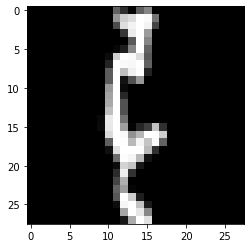

answer:9 を
predict:6.0 ま


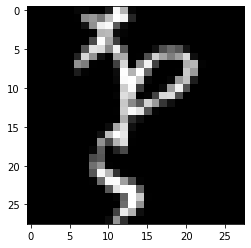

answer:3 つ
predict:3.0 つ


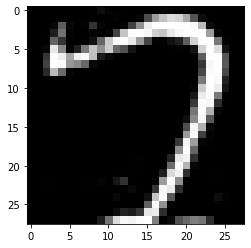

answer:8 れ
predict:1.0 き


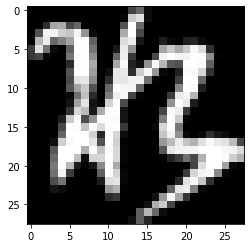

answer:3 つ
predict:3.0 つ


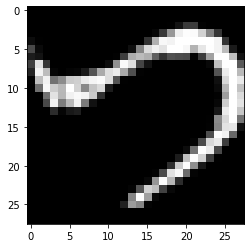

In [38]:
# trainデータを可視化。423のデータを確認してみる
for v in list(range(5)):
    print('answer:{} {}'.format(y_test[v], labelindex[y_test[v]]))
    print('predict:{} {}'.format(preds[v], labelindex[preds[v]]))
    plt.imshow(X_test[v].reshape(28, 28), cmap=plt.cm.gray)
    plt.show()
    

In [39]:
y_test.shape

(10000,)

In [40]:
# 実際の結果と、予測結果の混同行列(confusionmatrix)
confusion_matrix(y_test, preds)

array([[828,   5,   5,   8,  30,  37,   4,  38,  32,  13],
       [  2, 800,  44,   5,  27,  10,  53,   7,  21,  31],
       [  6,  32, 756,  56,  25,  13,  35,  14,  37,  26],
       [  2,  18,  44, 881,   8,  11,  11,   6,   9,  10],
       [ 43,  31,  39,  16, 749,   9,  40,  18,  27,  28],
       [  7,  27,  78,  16,  12, 800,  24,   4,  26,   6],
       [  6,  32,  85,  10,  22,  13, 807,   6,  11,   8],
       [ 18,  14,  23,   7,  56,   6,  46, 751,  50,  29],
       [ 10,  39,  26,  47,   2,  12,  25,   5, 830,   4],
       [  8,  35,  53,   7,  45,   5,  20,  25,  30, 772]], dtype=int64)

In [41]:
# 正解率
accuracy_score(y_test, preds)

0.7974